<a href="https://colab.research.google.com/github/Khik2219/Cryptocurrency-Price-Forecasting-Using-Hybrid-Models/blob/main/HybridModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q yfinance ta pandas numpy scikit-learn statsmodels \
                 xgboost==1.7.6 tensorflow==2.18.0 tqdm
from google.colab import files, drive
uploaded = files.upload()          # ↖ choose kaggle_cryptoOHLC_dataset.csv
csv_path = next(iter(uploaded))    # first file uploaded


Saving dataset.csv to dataset.csv


In [3]:
import pandas as pd, numpy as np, ta
print(pd.read_csv(csv_path, nrows=0).columns.tolist())

['Unnamed: 0', 'open', 'high', 'low', 'close', 'volume', 'marketCap', 'timestamp', 'crypto_name', 'date']


# 🏗️ 3. Data prep: engineer a few TA features


In [4]:
##############################################################################
# 🏗️ DATA PREP – load Kaggle CSV, drop/aggregate duplicates, engineer features
##############################################################################
import pandas as pd, numpy as np, ta

raw = pd.read_csv(csv_path, parse_dates=['date'])

# 1) lowercase columns and make sure datetime is index
df = (raw.rename(columns=str.lower)
          .set_index('date')
          .sort_index())

# 2) FIX — remove duplicate calendar days
#    Option A: keep the last record of each day
df = df[~df.index.duplicated(keep='last')]

#    ───────────── OR ─────────────
#    Option B: aggregate duplicates into daily OHLC
# df = (df.groupby(df.index)
#           .agg({
#               'open':'first',
#               'high':'max',
#               'low':'min',
#               'close':'last',
#               'volume':'sum',
#               'marketcap':'last'
#           }))

# 3) simple TA indicators
df['ret_1d'] = df['close'].pct_change()
df['sma_14'] = df['close'].rolling(14).mean()
df['rsi_14'] = ta.momentum.rsi(df['close'], 14)
df = df.dropna()

# 4) split 80 / 20
split = int(len(df)*0.8)
train, test = df.iloc[:split], df.iloc[split:]
y_train = train['close'].shift(-1).dropna()
y_test  = test['close'].shift(-1).dropna()
X_train_raw = train.loc[y_train.index]
X_test_raw  = test.loc[y_test.index]

print(f"✅ dataset ready – train rows: {len(train)}, test rows: {len(test)} (index unique)")


✅ dataset ready – train rows: 2588, test rows: 647 (index unique)


# 📉 4. Naïve baseline (“tomorrow = today”)

In [5]:
pred_naive = X_test_raw['close'].values  # vector, same length as y_test

# 🔮 5. SARIMAX (1,1,1)(1,1,1,7)



In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
arima = SARIMAX(y_train, order=(1,1,1), seasonal_order=(1,1,1,7),
                enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
pred_arima = arima.forecast(len(y_test))
pred_arima.index = y_test.index

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# 🌲 6. XGBoost on lag + return features

In [7]:
##############################################################################
# 🌲  XGBoost – robust alignment (handles duplicates & NaNs)
##############################################################################
from xgboost import XGBRegressor

def make_lags(df, col='close', lags=(1,2,3,7)):
    out = pd.DataFrame(index=df.index)
    for l in lags:
        out[f'lag_{l}'] = df[col].shift(l)
    out['ret_1d'] = df[col].pct_change()
    return out

# 1) If the CSV has duplicate calendar days, choose how to aggregate them.
#    Here we take the **last record of each day**; you could also `.mean()`.
daily = df[~df.index.duplicated(keep="last")]

# 2) Build lag features and the next‑day target in one frame
feat = make_lags(daily)
feat['y'] = daily['close'].shift(-1)        # next‑day close price

# 3) Drop any rows with NaNs (top rows, last row)
feat = feat.dropna()

# 4) Train/test split by the original pivot date
split_date = test.index[0]                  # first date of test set
train_mask = feat.index < split_date

X_train_xgb = feat.loc[train_mask].drop(columns='y')
y_train_xgb = feat.loc[train_mask, 'y']
X_test_xgb  = feat.loc[~train_mask].drop(columns='y')
y_test_xgb  = feat.loc[~train_mask, 'y']

# 5) Sanity check
assert X_train_xgb.isna().sum().sum() == 0
assert y_train_xgb.isna().sum()        == 0
assert len(X_train_xgb) == len(y_train_xgb)

# 6) Fit model
xgb = XGBRegressor(
        n_estimators=600, learning_rate=0.05, max_depth=5,
        subsample=0.8, colsample_bytree=0.8,
        objective='reg:squarederror', random_state=42
     ).fit(X_train_xgb, y_train_xgb)

pred_xgb = pd.Series(xgb.predict(X_test_xgb),
                     index=X_test_xgb.index)


# 🧠 7. Tiny LSTM  (30‑day window, 2×32 units, 10 epochs)

In [8]:
##############################################################################
# 🧠 LSTM  (30‑day window, 2×32 units, 10 epochs) – fixed alignment
##############################################################################
import tensorflow as tf, numpy as np, pandas as pd
tf.random.set_seed(0)
SEQ = 30

# --- helper for training ----------------------------------------------------
def make_train_sequences(X_raw, y, seq_len=SEQ):
    xs, ys = [], []
    closes = X_raw['close'].values
    for i in range(seq_len, len(X_raw)):
        xs.append(closes[i-seq_len:i])
        ys.append(y.iloc[i])
    return np.array(xs)[..., None], np.array(ys)

X_seq_tr, y_seq_tr = make_train_sequences(X_train_raw, y_train)

# --- helper for test  -------------------------------------------------------
def make_test_sequences(train_close, test_close, seq_len=SEQ):
    """
    Returns an array of shape (len(test), seq_len, 1).
    For the very first test row we borrow `seq_len` closes from the
    end of the train set, so every test date has a full 30‑day window.
    """
    concat = pd.concat([train_close.tail(seq_len), test_close])
    closes = concat['close'].values
    xs = [closes[i-seq_len:i] for i in range(seq_len, len(closes))]
    return np.array(xs)[..., None]

X_seq_te = make_test_sequences(X_train_raw, X_test_raw, seq_len=SEQ)

# --- model ------------------------------------------------------------------
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(SEQ, 1)),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1),
])
model.compile(optimizer="adam", loss="mse")
model.fit(X_seq_tr, y_seq_tr, epochs=10, batch_size=32, verbose=2)

pred_lstm = model.predict(X_seq_te, verbose=2).ravel()
pred_lstm = pd.Series(pred_lstm, index=y_test.index)


Epoch 1/10
80/80 - 5s - 66ms/step - loss: 1883063.8750
Epoch 2/10
80/80 - 2s - 20ms/step - loss: 1880131.6250
Epoch 3/10
80/80 - 2s - 20ms/step - loss: 1878797.8750
Epoch 4/10
80/80 - 2s - 20ms/step - loss: 1877613.8750
Epoch 5/10
80/80 - 2s - 30ms/step - loss: 1876488.2500
Epoch 6/10
80/80 - 2s - 22ms/step - loss: 1875397.5000
Epoch 7/10
80/80 - 3s - 32ms/step - loss: 1874333.6250
Epoch 8/10
80/80 - 2s - 20ms/step - loss: 1873291.5000
Epoch 9/10
80/80 - 2s - 20ms/step - loss: 1872267.8750
Epoch 10/10
80/80 - 3s - 32ms/step - loss: 1871262.2500
21/21 - 1s - 51ms/step


# 🤝 8. Hybrid models  (weighted mean + ridge stacking)

In [9]:
from sklearn.linear_model import RidgeCV
dfp = pd.DataFrame({
    'Naive': pred_naive,
    'ARIMA': pred_arima,
    'XGB':   pred_xgb,
    'LSTM':  pred_lstm,
    'y':     y_test
}).dropna()

# 8a weighted
w = np.array([0.2,0.3,0.5])   # ARIMA, XGB, LSTM
dfp['Hybrid_w'] = dfp[['ARIMA','XGB','LSTM']].values @ w

# 8b stacking
ridge = RidgeCV(alphas=np.logspace(-3,3,25)).fit(dfp[['ARIMA','XGB','LSTM']], dfp['y'])
dfp['Hybrid_stack'] = ridge.predict(dfp[['ARIMA','XGB','LSTM']])

# 📊 9. Metrics table

,RMSE,MAE,MAPE
Hybrid_stack,6890.88,2252.96,2.81e+12
ARIMA,6932.33,1737.32,2.15e+12
Hybrid_w,6964.02,1451.80,5.23e+11
XGB,6976.04,1683.18,2.11e+11
LSTM,7001.92,1249.92,7.41e+10
Naive,9544.80,2315.69,6.01e+11


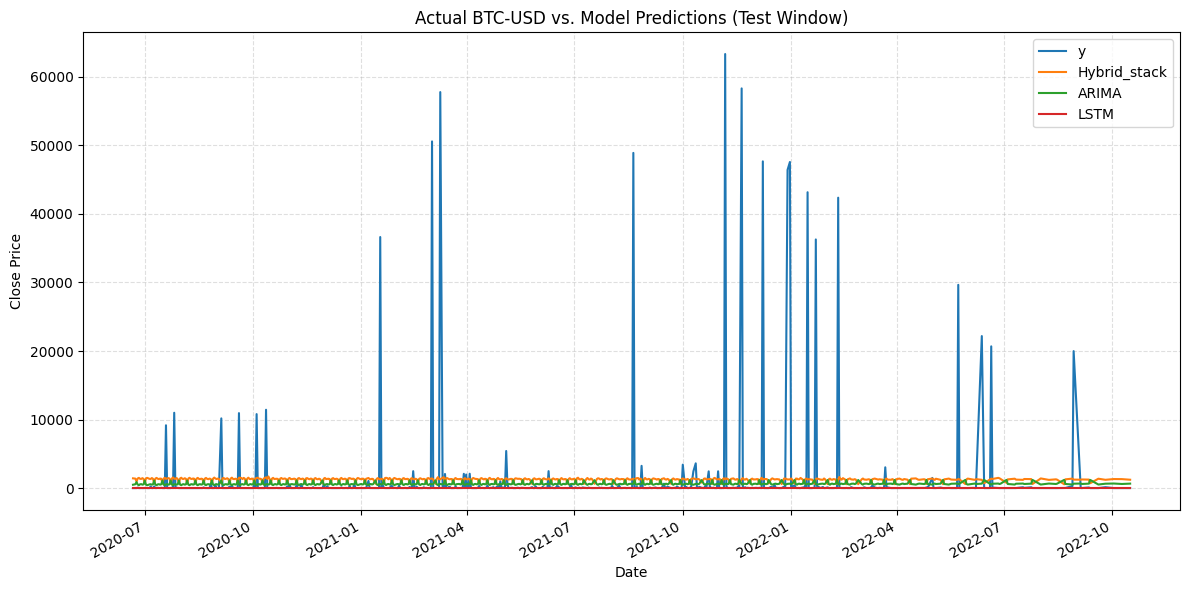

In [10]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn import metrics as skm
from sklearn.linear_model import RidgeCV

# ------------------------------------------------------------------
# 0) make sure the five raw objects exist
needed = ["pred_naive", "pred_arima", "pred_xgb", "pred_lstm", "y_test"]
missing = [v for v in needed if v not in globals()]
if missing:
    raise RuntimeError(f"Missing variables: {', '.join(missing)} – run model cells first.")

# ------------------------------------------------------------------
# 1) ensure every prediction is a Series indexed like y_test
def to_series(obj, name):
    if isinstance(obj, pd.Series):
        return obj.reindex(y_test.index)          # align
    elif isinstance(obj, np.ndarray):
        if len(obj) != len(y_test):
            raise ValueError(f"{name} length {len(obj)} ≠ y_test length {len(y_test)}")
        return pd.Series(obj, index=y_test.index, name=name)
    else:
        raise TypeError(f"{name} must be Series or ndarray, got {type(obj)}")

dfp = pd.concat(
    {
        "Naive":  to_series(pred_naive,  "Naive"),
        "ARIMA":  to_series(pred_arima,  "ARIMA"),
        "XGB":    to_series(pred_xgb,    "XGB"),
        "LSTM":   to_series(pred_lstm,   "LSTM"),
        "y":      to_series(y_test,      "y"),
    },
    axis=1
).dropna()

# ------------------------------------------------------------------
# 2) add hybrid predictions
weights = np.array([0.2, 0.3, 0.5])          # ARIMA, XGB, LSTM
dfp["Hybrid_w"] = dfp[["ARIMA", "XGB", "LSTM"]].values @ weights

ridge = RidgeCV(alphas=np.logspace(-3, 3, 25))
ridge.fit(dfp[["ARIMA", "XGB", "LSTM"]], dfp["y"])
dfp["Hybrid_stack"] = ridge.predict(dfp[["ARIMA", "XGB", "LSTM"]])

# ------------------------------------------------------------------
# 3) metric table
def mape(y_true, y_pred): return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
models = ["Naive", "ARIMA", "XGB", "LSTM", "Hybrid_w", "Hybrid_stack"]

metrics = {
    m: dict(
        RMSE=np.sqrt(skm.mean_squared_error(dfp["y"], dfp[m])),
        MAE =skm.mean_absolute_error(dfp["y"], dfp[m]),
        MAPE=mape(dfp["y"], dfp[m]),
    ) for m in models
}
metrics_df = pd.DataFrame(metrics).T.sort_values("RMSE")
display(metrics_df.style.format({"RMSE":"{:.2f}", "MAE":"{:.2f}", "MAPE":"{:.2e}"}))

# ------------------------------------------------------------------
# 4) time‑series plot
plt.figure(figsize=(12, 6))
plot_cols = ["y", "Hybrid_stack", "ARIMA", "LSTM"]
dfp[plot_cols].plot(ax=plt.gca())
plt.title("Actual BTC‑USD vs. Model Predictions (Test Window)")
plt.ylabel("Close Price")
plt.xlabel("Date")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(plot_cols)
plt.tight_layout()


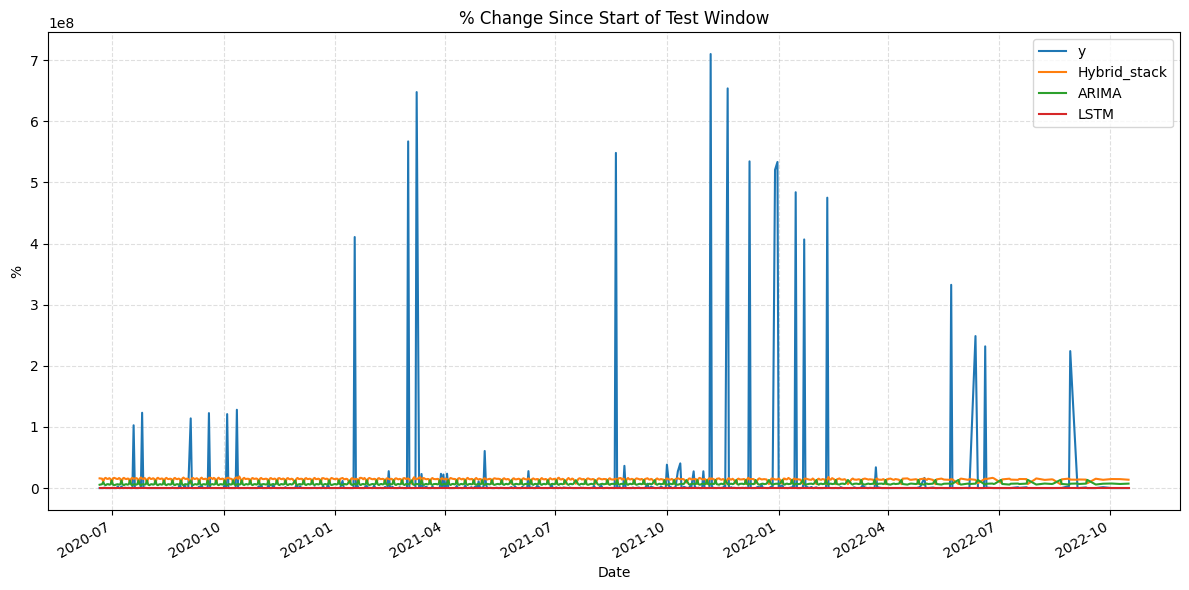

In [11]:
# % change relative to first test day
df_pct = dfp.div(dfp['y'].iloc[0]).sub(1) * 100     # % change

plt.figure(figsize=(12,6))
plot_cols = ['y', 'Hybrid_stack', 'ARIMA', 'LSTM']
df_pct[plot_cols].plot(ax=plt.gca())
plt.title('% Change Since Start of Test Window')
plt.ylabel('%')
plt.xlabel('Date')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(plot_cols)
plt.tight_layout()


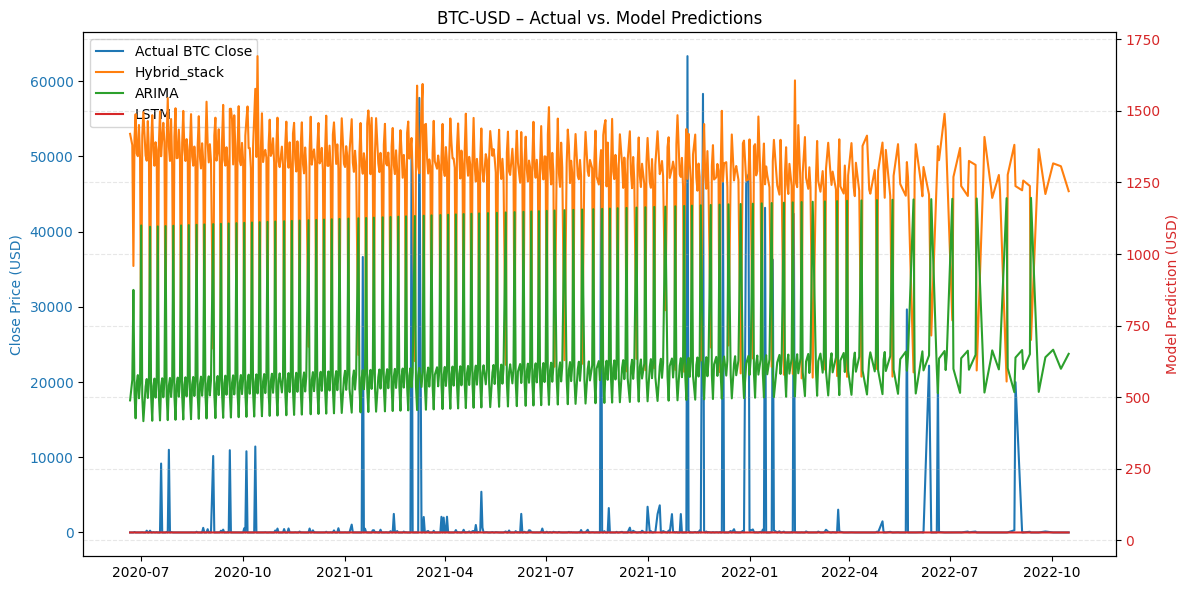

In [12]:
fig, ax1 = plt.subplots(figsize=(12,6))

# left axis: actual close price
ax1.plot(dfp.index, dfp['y'], color='tab:blue', label='Actual BTC Close')
ax1.set_ylabel('Close Price (USD)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# right axis: model predictions
ax2 = ax1.twinx()
ax2.plot(dfp.index, dfp['Hybrid_stack'], color='tab:orange', label='Hybrid_stack')
ax2.plot(dfp.index, dfp['ARIMA'],        color='tab:green',  label='ARIMA')
ax2.plot(dfp.index, dfp['LSTM'],         color='tab:red',    label='LSTM')
ax2.set_ylabel('Model Prediction (USD)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# legends
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

plt.title('BTC‑USD – Actual vs. Model Predictions')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
